(2140, 96, 96, 1)
(2140, 30)


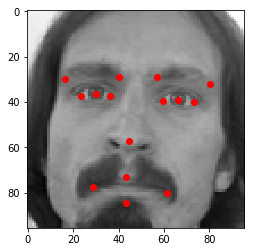

In [7]:
#####  LOADING AND EXTRACTING DATA   #####
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('./data/training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
    #imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array

  


# This snippet is just to check/verify data
imgs, labels = data_loader()
print(imgs.shape)
print(labels.shape)

n=0
labels[n] = (labels[n]*48)+48
image = np.squeeze(imgs[n])
plt.imshow(image, cmap='gray')
plt.plot(labels[n][::2], labels[n][1::2], 'ro')
plt.show()
    

In [18]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('my_model.h5')

Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Train on 1712 samples, validate on 428 samples
Epoch 1/2
1712/1712 [==============================] - 12s 7ms/step - loss: 0.0229 - acc: 0.5426 - val_loss: 0.0089 - val_acc: 0.4322

Epoch 00001: val_loss improved from inf to 0.00891, saving model to checkpoint1.hdf5
Epoch 2/2
1712/1712 [==============================] - 11s 6ms/step - loss: 0.0068 - acc: 0.7085 - val_loss: 0.0077 - val_acc: 0.4322

Epoch 00002: val_loss improved from 0.00891 to 0.00770, saving model to checkpoint1.hdf5


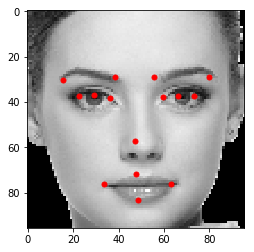

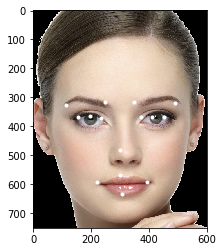

In [17]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####


import cv2
# from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('my_model_prime.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('images/face-png-free-image-download-6.png')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()




In [25]:
from my_CNN_model import *
import cv2
import numpy as np

# Load the model built in the previous step
my_model = load_my_CNN_model('my_model')

# Face cascade to detect faces
face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Define filters
filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filterIndex = 0

# Load the video
camera = cv2.VideoCapture(0)

# Keep looping
while True:
    # Grab the current paintWindow
    (grabbed, frame) = camera.read()
    frame = cv2.flip(frame, 1)
    frame2 = np.copy(frame)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add the 'Next Filter' button to the frame
    frame = cv2.rectangle(frame, (500,10), (620,65), (235,50,50), -1)
    cv2.putText(frame, "NEXT FILTER", (512, 37), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)

    # Determine which pixels fall within the blue boundaries and then blur the binary image
    blueMask = cv2.inRange(hsv, blueLower, blueUpper)
    blueMask = cv2.erode(blueMask, kernel, iterations=2)
    blueMask = cv2.morphologyEx(blueMask, cv2.MORPH_OPEN, kernel)
    blueMask = cv2.dilate(blueMask, kernel, iterations=1)

    # Find contours (bottle cap in my case) in the image
    (cnts, _) = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,
    	cv2.CHAIN_APPROX_SIMPLE)
    center = None

    # Check to see if any contours were found
    if len(cnts) > 0:
    	# Sort the contours and find the largest one -- we
    	# will assume this contour correspondes to the area of the bottle cap
        cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        # Get the radius of the enclosing circle around the found contour
        ((x, y), radius) = cv2.minEnclosingCircle(cnt)
        # Draw the circle around the contour
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        # Get the moments to calculate the center of the contour (in this case Circle)
        M = cv2.moments(cnt)
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

##       if center[1] <= 65:
##            if 500 <= center[0] <= 620: # Next Filter
        filterIndex += 1
        filterIndex %= 6
##                continue

    for (x, y, w, h) in faces:

        # Grab the face
        gray_face = gray[y:y+h, x:x+w]
        color_face = frame[y:y+h, x:x+w]

        # Normalize to match the input format of the model - Range of pixel to [0, 1]
        gray_normalized = gray_face / 255

        # Resize it to 96x96 to match the input format of the model
        original_shape = gray_face.shape # A Copy for future reference
        face_resized = cv2.resize(gray_normalized, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_copy = face_resized.copy()
        face_resized = face_resized.reshape(1, 96, 96, 1)

        # Predicting the keypoints using the model
        keypoints = my_model.predict(face_resized)

        # De-Normalize the keypoints values
        keypoints = keypoints * 48 + 48

        # Map the Keypoints back to the original image
        face_resized_color = cv2.resize(color_face, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_color2 = np.copy(face_resized_color)

        # Pair them together
        points = []
        for i, co in enumerate(keypoints[0][0::2]):
            points.append((co, keypoints[0][1::2][i]))

        # Add FILTER to the frame
        sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
        sunglass_width = int((points[7][0]-points[9][0])*1.1)
        sunglass_height = int((points[10][1]-points[8][1])/1.1)
        sunglass_resized = cv2.resize(sunglasses, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
        transparent_region = sunglass_resized[:,:,:3] != 0
        
        face_resized_color[int(points[9][1]):int(points[9][1])+sunglass_height, int(points[9][0]):int(points[9][0])+sunglass_width,:][transparent_region] = sunglass_resized[:,:,:3][transparent_region]

        # Resize the face_resized_color image back to its original shape
        frame[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)

        # Add KEYPOINTS to the frame2
        for keypoint in points:
            cv2.circle(face_resized_color2, keypoint, 1, (0,255,0), 1)

        frame2[y:y+h, x:x+w] = cv2.resize(face_resized_color2, original_shape, interpolation = cv2.INTER_CUBIC)

        # Show the frame and the frame2
        cv2.imshow("Selfie Filters", frame)
        cv2.imshow("Facial Keypoints", frame2)

    # If the 'q' key is pressed, stop the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()
